<a href="https://colab.research.google.com/github/Balogunhabeeb14/Petroleum-Target-Xplorer/blob/main/Xpl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from utilities import *

In [ ]:
# Load all sheets from the Excel file
file_path='/content/Passey.xlsx'
dfs=load_excel_sheets(file_path)

# Create list of tuples containing DataFrame and sheet name
df_list = [(df, sheet_name) for sheet_name, df in dfs.items()]

In [ ]:
# Access the loaded DataFrames
data_summary_df = dfs['Data Summary']
KR2 = dfs['TOC-ESTM (KR-2)']
KR3_edit = dfs['TOC-ESTM (KR-3) (edittt)']
KR3=dfs['TOC-ESTM (KR-3)']
sheet2_df = dfs['Sheet2']
sheet1_df = dfs['Sheet1']

In [ ]:
data_summary_df.head(40)

The data summary provides us with the metadata for the data. Herein, few observations found includes:

- Litho-logs comprise features {Spectral Gamma, GR, SP, Mud-log, Caliper}
- Porosity	comprises features {DT,	RHOB, CNL}
- RES	comprises features {LLD, LLS}
- Biostratigraphic Data
- Well-Tops/Formation Tops
- Reports	comprises features {Geologic,	Rock-Eval}
- Rock-Eval	comprises features {S1, S2, S3,	HI,	OI, VR,	TOC, Tmax}

These features were collected mostly for Kolmani river 2(KR2) and Kolmani river 3(KR3). To have a fair analysis, we will only include features that are available in both KR2 & KR3.

PS. Most of the Multivariate linear regression analysis was repeated to confirm the dependent variable, what was discovered was that, the TOC(measured) was the actual variable predicted across all analysis.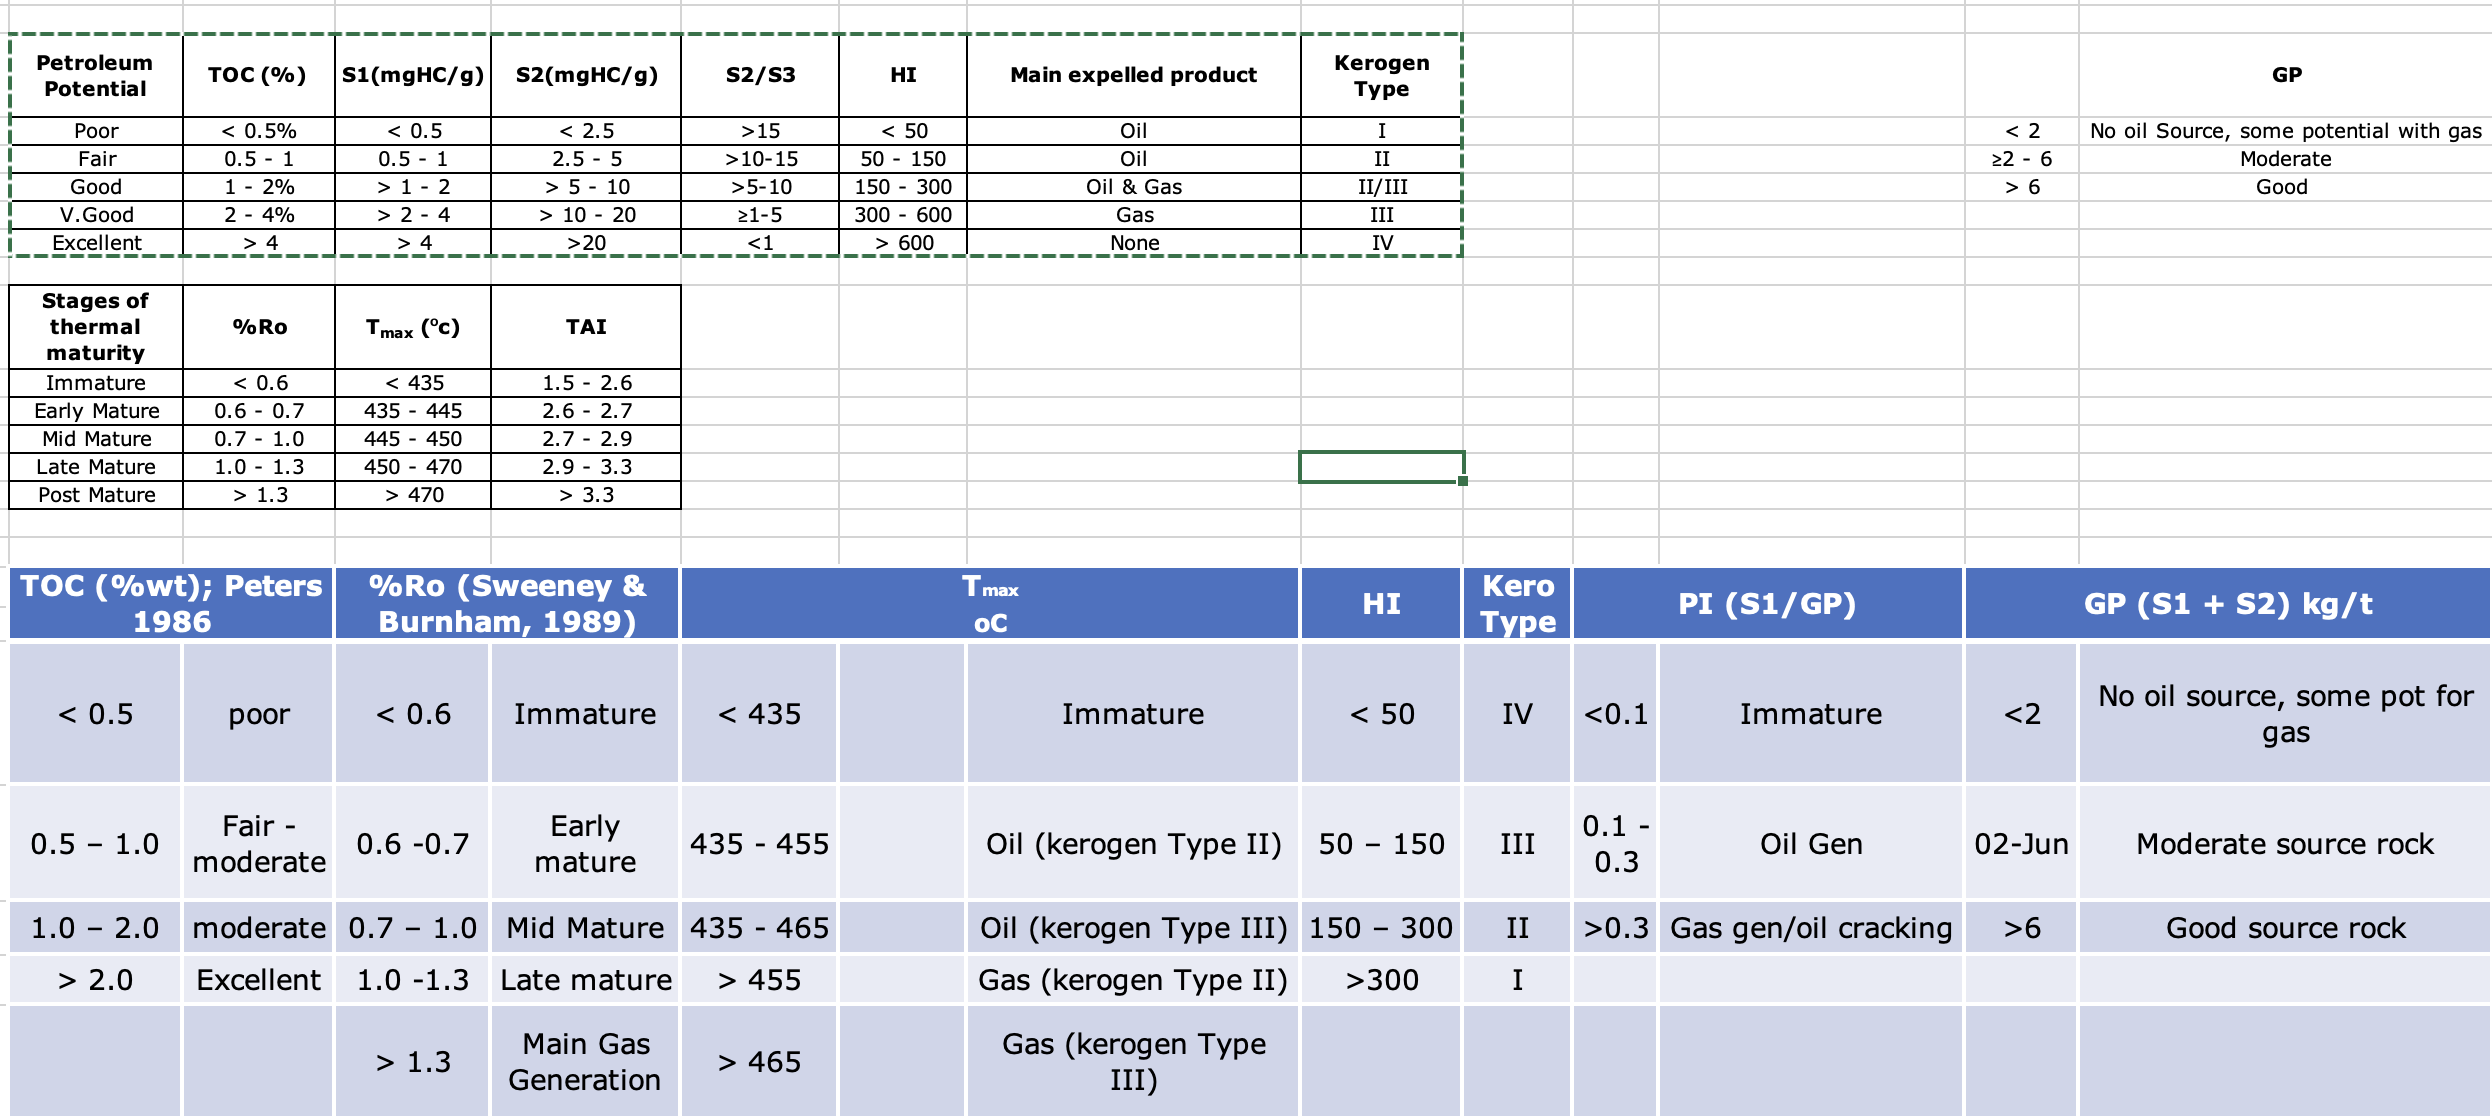



In [ ]:
# Drop 'MD' column from KR2 dataframe
KR2 = KR2.drop('MD', axis=1)

# Drop 'MD'
#measure Toc and Measured-TOC.1 in KR3 are same, so we drop one
# Drop 'Measured-TOC.1' column from KR3 dataframe, likwise TOC RK eval
KR3 = KR3.drop(['MD','Measured-TOC.1','TOC (Rk-Eval)'], axis=1)

#This is because in the MVA, there was no signle equation that considered MD, TOC (Rk-Eval)
# Drop unnamed columns from the DataFrame
KR2 = drop_unnamed_columns(KR2)
KR3 = drop_unnamed_columns(KR3)

In [ ]:
KR2.columns

In [ ]:
KR3.columns

In [ ]:
missing_value_percent(KR2)

In [ ]:
 missing_value_percent(KR3)

In [ ]:
KR2.describe().T

In [ ]:
KR3.describe().T

In [ ]:
#drop columns with more than 70% missingness
KR2 = drop_high_missing_columns(KR2, threshold=70)
KR3 = drop_high_missing_columns(KR3, threshold=70)

In [ ]:
KR2.info()

In [ ]:
KR3.info()

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats

def check_normality(df):
    """
    Check the normality of features in a DataFrame.

    Parameters:
        df (DataFrame): The DataFrame containing the features.

    Returns:
        None
    """
    for column in df.columns:
        plt.figure(figsize=(10, 4))

        # Histogram
        plt.subplot(1, 2, 1)
        df[column].plot(kind='hist', bins=20, edgecolor='black', alpha=0.7)
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')

        # Q-Q plot
        plt.subplot(1, 2, 2)
        stats.probplot(df[column].dropna(), dist="norm", plot=plt)
        plt.title(f'Q-Q Plot of {column}')
        plt.xlabel('Theoretical quantiles')
        plt.ylabel('Sample quantiles')

        plt.tight_layout()
        plt.show()

        # Shapiro-Wilk test for normality
        stat, p = stats.shapiro(df[column].dropna())
        print(f'Feature: {column}, Shapiro-Wilk Test Statistic: {stat}, p-value: {p}')
        if p > 0.05:
            print(f"The feature '{column}' appears to be approximately normally distributed.\n")
        else:
            print(f"The feature '{column}' does not appear to be normally distributed.\n")

In [ ]:
check_normality(KR2)

In [ ]:
check_normality(KR3)

In [ ]:
import pandas as pd
import numpy as np

def impute_missing(df):
    """
    Impute missing values in a DataFrame using appropriate methods based on the data distribution.

    Parameters:
        df (DataFrame): The DataFrame containing the features.

    Returns:
        DataFrame: The DataFrame with missing values imputed.
    """
    for column in df.columns:
        if df[column].dtype == 'object':
            # For categorical data, impute with mode
            mode_val = df[column].mode()[0]
            df[column].fillna(mode_val, inplace=True)
            print(f"Imputed missing values in '{column}' with mode: {mode_val}")
        elif np.abs(df[column].skew()) > 1:
            # For highly skewed numerical data, impute with median
            median_val = df[column].median()
            df[column].fillna(median_val, inplace=True)
            print(f"Imputed missing values in '{column}' with median: {median_val}")
        else:
            # For approximately normally distributed numerical data, impute with mean
            mean_val = df[column].mean()
            df[column].fillna(mean_val, inplace=True)
            print(f"Imputed missing values in '{column}' with mean: {mean_val}")

    return df


In [ ]:
impute_missing(KR2)

In [ ]:
impute_missing(KR3)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_matrix(df):
    """
    Plot correlation matrix and identify multicollinearity.

    Parameters:
        df (DataFrame): The DataFrame containing the features.

    Returns:
        None
    """
    # Calculate correlation matrix
    corr_matrix = df.corr()

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f",annot_kws={"size": 8, "color": 'black'})
    plt.title('Correlation Matrix')
    plt.show()

    # Check for multicollinearity
    collinear_features = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > 0.7:
                colname = corr_matrix.columns[i]
                collinear_features.add(colname)

    if collinear_features:
        print("The following variables are highly correlated (>|0.7|):")
        print(collinear_features)
    else:
        print("No multicollinearity detected.")

In [ ]:
plot_correlation_matrix(KR2)

In [ ]:
plot_correlation_matrix(KR3)

In [ ]:
import numpy as np
df1=KR2.copy()
df1=df1.dropna()

# Separate features and target
X = df1.drop('Measured-TOC', axis=1)
y = df1['Measured-TOC']

# Call the function
plot_feature_importances_regression(X, y)

In [ ]:
def evaluate_regression_model(X, y):
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define and train the regression model
    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)

    # Plot true vs predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color='blue', label='Predictions')  # Predicted values in blue
    plt.scatter(y_test, y_test, color='red', label='True Values')  # True values in red
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title("TOC prediction for Kolmani river 2")
    plt.grid(True)
    plt.legend()

    # Display evaluation metrics on the chart
    metrics_text = f"MSE: {mse:.2f}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\nR^2: {r_squared:.2f}"
    plt.text(0.95, 0.05, metrics_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')

    plt.tight_layout()
    plt.show()

evaluate_regression_model(X,y)

In [ ]:
import numpy as np
df2=KR3.copy()
df2=df2.dropna()

# Separate features and target
X = df2.drop('Measured-TOC', axis=1)
y = df2['Measured-TOC']

# Call the function
plot_feature_importances_regression(X, y)

In [ ]:
def evaluate_regression_model(X, y):
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define and train the regression model
    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)

    # Plot true vs predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color='blue', label='Predictions')  # Predicted values in blue
    plt.scatter(y_test, y_test, color='red', label='True Values')  # True values in red
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title("TOC prediction for Kolmani river 3")
    plt.grid(True)
    plt.legend()

    # Display evaluation metrics on the chart
    metrics_text = f"MSE: {mse:.2f}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\nR^2: {r_squared:.2f}"
    plt.text(0.95, 0.05, metrics_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')

    plt.tight_layout()
    plt.show()


evaluate_regression_model(X,y)

Investigate the model from a classification point. Here there is a classification boundary in Passey excel file, exactly on Sheet 1 of the file.

The category is as follows.
    if toc_value < 0.5:
        return 'Poor'
    elif 0.5 <= toc_value < 1:
        return 'Fair'
    elif 1 <= toc_value < 2:
        return 'Good'
    elif 2 <= toc_value < 4:
        return 'V.Good'
    else:
        return 'Excellent'
However, we will reformat this to binary class and have.

if 0.5 <= toc_value < 1:
        return 'Fair'
    elif 1 <= toc_value < 4:
        return 'Good'


In [ ]:
def categorize_toc(toc_value):
    """
    Categorize Measured TOC values into qualitative labels.

    Parameters:
    toc_value (float): Measured TOC value.

    Returns:
    str: Categorical label.
    """
    if 0.5< toc_value < 1:
        return '0' #fair
    elif 1 <= toc_value < 4:
        return '1' #good

In [ ]:
KR2_cla = KR2.copy()
KR3_cla = KR3.copy()

In [ ]:
# Apply categorization function to 'Measured-TOC' column
KR2_cla['TOC_Category'] = KR2_cla['Measured-TOC'].apply(categorize_toc).astype(float)
KR3_cla['TOC_Category'] = KR3_cla['Measured-TOC'].apply(categorize_toc).astype(float)

In [ ]:
KR2_cla.head()

In [ ]:
KR3_cla.head()

In [ ]:
# Drop 'MEasured-TOC' column from KR2 & KR3 dataframe
KR2_cla = KR2_cla.drop('Measured-TOC', axis=1)
KR3_cla = KR3_cla.drop('Measured-TOC', axis=1)

In [ ]:
KR2_cla=KR2_cla.dropna()
KR3_cla=KR3_cla.dropna()

In [ ]:
X = KR2_cla.drop('TOC_Category', axis=1)
y = KR2_cla['TOC_Category']

y.value_counts().plot.bar()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import time
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
random_state = 123

# Record the start time
start_time = time.time()

cv = StratifiedKFold(5)
visualizer = RFECV(RandomForestClassifier(), cv=cv, scoring='accuracy')

visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
visualizer.show()

# Access the selected features
selected_features = visualizer.support_

# Print the indices of selected features
print("Selected Features Indices:", [i for i, selected in enumerate(selected_features) if selected])


# Record the end time
end_time = time.time()

# Calculate the time taken
time_taken = end_time - start_time

# Print the time taken
print(f"Time taken: {time_taken} seconds")

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import Lasso

# Define the number of outer folds for nested cross-validation
n_outer_splits = 5

# Define classifiers and their hyperparameter grids
classifiers = {
    'Gradient Boosting': (GradientBoostingClassifier(), {'learning_rate': [0.01, 0.1, 0.5], 'n_estimators': [50, 100, 200]}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]}),
    'Naive Bayes': (GaussianNB(), {'var_smoothing': [1e-9, 1e-7, 1e-5]}),
    'MLP': (MLPClassifier(activation='logistic'), {'hidden_layer_sizes': [(50,), (100,), (200,)], 'alpha': [0.0001, 0.001, 0.01]}),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [50, 100, 200], 'max_features': ['sqrt', 'log2']}),
    'SVM Linear': (SVC(kernel='linear'), {'C': [0.1, 1, 10]}),
    'SVM Poly': (SVC(kernel='poly'), {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}),
    'SVM Radial': (SVC(kernel='rbf'), {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}),
    'Logistic Regression': (LogisticRegression(), {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}),
    'AdaBoost': (AdaBoostClassifier(), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.5]}),
    'Lasso Logistic': (LogisticRegression(penalty='l1', solver='liblinear'), {'C': [0.1, 1, 10]}),
    'Discriminant Analysis': (LinearDiscriminantAnalysis(), {}),
    'Decision Tree': (DecisionTreeClassifier(), {'max_depth': [None, 10, 20, 30]})
}

# Define evaluation metrics
metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'f1': f1_score
}

# Initialize stratified k-fold cross-validator for outer loop
outer_cv = StratifiedKFold(n_splits=n_outer_splits, shuffle=True, random_state=42)

# Define your feature matrix X and target vector y here
X = KR2_cla.drop('TOC_Category', axis=1)
y = KR2_cla['TOC_Category']

# Initialize a dictionary to store the best hyperparameters for each model
best_hyperparameters = {}

# Initialize dictionaries to store mean and standard deviation of scores for each metric
mean_scores = {metric: [] for metric in metrics}
std_scores = {metric: [] for metric in metrics}

# Iterate over each model
for name, (model, param_grid) in classifiers.items():
    print(f"Evaluating {name}:")

    # Initialize lists to store metric scores across outer folds
    mean_scores[name] = {metric: [] for metric in metrics}

    # Perform nested cross-validation
    for train_index, test_index in outer_cv.split(X, y):
        X_train_outer, X_test_outer = X.iloc[train_index], X.iloc[test_index]
        y_train_outer, y_test_outer = y.iloc[train_index], y.iloc[test_index]

        # Initialize stratified k-fold cross-validator for inner loop
        inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        # Initialize dictionaries to store metric scores across inner folds
        inner_scores = {metric: [] for metric in metrics}

        # Perform inner cross-validation for hyperparameter tuning
        for inner_train_index, inner_val_index in inner_cv.split(X_train_outer, y_train_outer):
            X_train_inner, X_val_inner = X_train_outer.iloc[inner_train_index], X_train_outer.iloc[inner_val_index]
            y_train_inner, y_val_inner = y_train_outer.iloc[inner_train_index], y_train_outer.iloc[inner_val_index]

            # Hyperparameter tuning using grid search
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy')
            grid_search.fit(X_train_inner, y_train_inner)
            best_model = grid_search.best_estimator_

            # Train the best model on the training fold of the inner loop
            best_model.fit(X_train_inner, y_train_inner)

            # Make predictions on the validation fold of the inner loop
            y_pred_inner = best_model.predict(X_val_inner)

            # Compute evaluation metrics for the inner fold
            for metric_name, metric_func in metrics.items():
                score = metric_func(y_val_inner, y_pred_inner)
                inner_scores[metric_name].append(score)

        # Compute mean scores across inner folds for each metric
        for metric_name in metrics.keys():
            mean_score = np.mean(inner_scores[metric_name])
            mean_scores[name][metric_name].append(mean_score)

    # Compute mean and standard deviation of scores across outer folds for each metric
    for metric_name in metrics.keys():
        mean_score = np.mean(mean_scores[name][metric_name])
        std_score = np.std(mean_scores[name][metric_name])
        print(f"Mean {metric_name}: {mean_score:.4f}, Std: {std_score:.4f}")

    # Find the best metric and its corresponding score
    best_metric = max(mean_scores[name], key=lambda x: np.mean(mean_scores[name][x]))
    best_mean_score = np.mean(mean_scores[name][best_metric])

    # Store the best hyperparameters for the model
    best_hyperparameters[name] = grid_search.best_params_

    print(f"Best {best_metric} Score: {best_mean_score:.4f}")
    print(f"Best Hyperparameters: {best_hyperparameters[name]}")
    print("\n")

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import numpy as np

# Define classifiers and their hyperparameter grids
classifiers = {
    'Gradient Boosting': GradientBoostingClassifier(learning_rate=0.01, n_estimators=200),
    'KNN': KNeighborsClassifier(n_neighbors=7),
    'Naive Bayes': GaussianNB(var_smoothing=1e-09),
    'MLP': MLPClassifier(activation='logistic', alpha=0.0001, hidden_layer_sizes=(100,)),
    'Random Forest': RandomForestClassifier(n_estimators=50, max_features='log2'),
    'SVM Linear': SVC(kernel='linear', C=0.1,probability=True),
    'SVM Poly': SVC(kernel='poly', C=0.1, degree=3,probability=True),
    'SVM Radial': SVC(kernel='rbf', C=1, gamma='scale',probability=True),
    'Logistic Regression': LogisticRegression(C=0.1, penalty='l2'),
    'AdaBoost': AdaBoostClassifier(n_estimators=50, learning_rate=0.1),
    'Discriminant Analysis': LinearDiscriminantAnalysis(),
    'Decision Tree': DecisionTreeClassifier(max_depth=30)
}

# Define your feature matrix X and target vector y here
X = KR2_cla.drop('TOC_Category', axis=1)
y = KR2_cla['TOC_Category']

# Initialize StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Plot ROC curve for each classifier with error bars
plt.figure(figsize=(10, 8))
for name, classifier in classifiers.items():
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        classifier.fit(X_train, y_train)
        probas_ = classifier.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    # Compute error bars
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

    plt.plot(mean_fpr, mean_tpr, label=f'{name} (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})')
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [ ]:
X = KR3_cla.drop('TOC_Category', axis=1)
y = KR3_cla['TOC_Category']

y.value_counts().plot.bar()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import time
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
random_state = 123

# Record the start time
start_time = time.time()

cv = StratifiedKFold(5)
visualizer = RFECV(RandomForestClassifier(), cv=cv, scoring='accuracy')

visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
visualizer.show()

# Access the selected features
selected_features = visualizer.support_

# Print the indices of selected features
print("Selected Features Indices:", [i for i, selected in enumerate(selected_features) if selected])


# Record the end time
end_time = time.time()

# Calculate the time taken
time_taken = end_time - start_time

# Print the time taken
print(f"Time taken: {time_taken} seconds")

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import Lasso

# Define the number of outer folds for nested cross-validation
n_outer_splits = 5

# Define classifiers and their hyperparameter grids
classifiers = {
    'Gradient Boosting': (GradientBoostingClassifier(), {'learning_rate': [0.01, 0.1, 0.5], 'n_estimators': [50, 100, 200]}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]}),
    'Naive Bayes': (GaussianNB(), {'var_smoothing': [1e-9, 1e-7, 1e-5]}),
    'MLP': (MLPClassifier(activation='logistic'), {'hidden_layer_sizes': [(50,), (100,), (200,)], 'alpha': [0.0001, 0.001, 0.01]}),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [50, 100, 200], 'max_features': ['sqrt', 'log2']}),
    'SVM Linear': (SVC(kernel='linear'), {'C': [0.1, 1, 10]}),
    'SVM Poly': (SVC(kernel='poly'), {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}),
    'SVM Radial': (SVC(kernel='rbf'), {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}),
    'Logistic Regression': (LogisticRegression(), {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}),
    'AdaBoost': (AdaBoostClassifier(), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.5]}),
    'Lasso Logistic': (LogisticRegression(penalty='l1', solver='liblinear'), {'C': [0.1, 1, 10]}),
    'Discriminant Analysis': (LinearDiscriminantAnalysis(), {}),
    'Decision Tree': (DecisionTreeClassifier(), {'max_depth': [None, 10, 20, 30]})
}

# Define evaluation metrics
metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'f1': f1_score
}

# Initialize stratified k-fold cross-validator for outer loop
outer_cv = StratifiedKFold(n_splits=n_outer_splits, shuffle=True, random_state=42)

# Define your feature matrix X and target vector y here
X = KR3_cla.drop('TOC_Category', axis=1)
y = KR3_cla['TOC_Category']

# Initialize a dictionary to store the best hyperparameters for each model
best_hyperparameters = {}

# Initialize dictionaries to store mean and standard deviation of scores for each metric
mean_scores = {metric: [] for metric in metrics}
std_scores = {metric: [] for metric in metrics}

# Iterate over each model
for name, (model, param_grid) in classifiers.items():
    print(f"Evaluating {name}:")

    # Initialize lists to store metric scores across outer folds
    mean_scores[name] = {metric: [] for metric in metrics}

    # Perform nested cross-validation
    for train_index, test_index in outer_cv.split(X, y):
        X_train_outer, X_test_outer = X.iloc[train_index], X.iloc[test_index]
        y_train_outer, y_test_outer = y.iloc[train_index], y.iloc[test_index]

        # Initialize stratified k-fold cross-validator for inner loop
        inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        # Initialize dictionaries to store metric scores across inner folds
        inner_scores = {metric: [] for metric in metrics}

        # Perform inner cross-validation for hyperparameter tuning
        for inner_train_index, inner_val_index in inner_cv.split(X_train_outer, y_train_outer):
            X_train_inner, X_val_inner = X_train_outer.iloc[inner_train_index], X_train_outer.iloc[inner_val_index]
            y_train_inner, y_val_inner = y_train_outer.iloc[inner_train_index], y_train_outer.iloc[inner_val_index]

            # Hyperparameter tuning using grid search
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy')
            grid_search.fit(X_train_inner, y_train_inner)
            best_model = grid_search.best_estimator_

            # Train the best model on the training fold of the inner loop
            best_model.fit(X_train_inner, y_train_inner)

            # Make predictions on the validation fold of the inner loop
            y_pred_inner = best_model.predict(X_val_inner)

            # Compute evaluation metrics for the inner fold
            for metric_name, metric_func in metrics.items():
                score = metric_func(y_val_inner, y_pred_inner)
                inner_scores[metric_name].append(score)

        # Compute mean scores across inner folds for each metric
        for metric_name in metrics.keys():
            mean_score = np.mean(inner_scores[metric_name])
            mean_scores[name][metric_name].append(mean_score)

    # Compute mean and standard deviation of scores across outer folds for each metric
    for metric_name in metrics.keys():
        mean_score = np.mean(mean_scores[name][metric_name])
        std_score = np.std(mean_scores[name][metric_name])
        print(f"Mean {metric_name}: {mean_score:.4f}, Std: {std_score:.4f}")

    # Find the best metric and its corresponding score
    best_metric = max(mean_scores[name], key=lambda x: np.mean(mean_scores[name][x]))
    best_mean_score = np.mean(mean_scores[name][best_metric])

    # Store the best hyperparameters for the model
    best_hyperparameters[name] = grid_search.best_params_

    print(f"Best {best_metric} Score: {best_mean_score:.4f}")
    print(f"Best Hyperparameters: {best_hyperparameters[name]}")
    print("\n")

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import numpy as np

# Define classifiers and their hyperparameter grids
classifiers = {
    'Gradient Boosting': GradientBoostingClassifier(learning_rate=0.01, n_estimators=200),
    'KNN': KNeighborsClassifier(n_neighbors=7),
    'Naive Bayes': GaussianNB(var_smoothing=1e-09),
    'MLP': MLPClassifier(activation='logistic', alpha=0.0001, hidden_layer_sizes=(100,)),
    'Random Forest': RandomForestClassifier(n_estimators=50, max_features='log2'),
    'SVM Linear': SVC(kernel='linear', C=0.1,probability=True),
    'SVM Poly': SVC(kernel='poly', C=0.1, degree=3,probability=True),
    'SVM Radial': SVC(kernel='rbf', C=1, gamma='scale',probability=True),
    'Logistic Regression': LogisticRegression(C=0.1, penalty='l2'),
    'AdaBoost': AdaBoostClassifier(n_estimators=50, learning_rate=0.1),
    'Discriminant Analysis': LinearDiscriminantAnalysis(),
    'Decision Tree': DecisionTreeClassifier(max_depth=30)
}

# Define your feature matrix X and target vector y here
X = KR3_cla.drop('TOC_Category', axis=1)
y = KR3_cla['TOC_Category']

# Initialize StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Plot ROC curve for each classifier with error bars
plt.figure(figsize=(10, 8))
for name, classifier in classifiers.items():
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        classifier.fit(X_train, y_train)
        probas_ = classifier.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    # Compute error bars
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

    plt.plot(mean_fpr, mean_tpr, label=f'{name} (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})')
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
